In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-scs/data_fold0.zip

In [3]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 40

SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [4]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
fold_df = pd.read_csv('/kaggle/input/5folds/5folds.csv')

In [8]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [9]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [10]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [11]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [12]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [13]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [14]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
35944,3176621688,Left Subarticular Stenosis,L5/S1,Normal/Mild,2,3824674869,5,144.906129,161.204633,Axial T2
35949,3176621688,Right Subarticular Stenosis,L5/S1,Moderate,2,3824674869,5,118.441164,161.742044,Axial T2


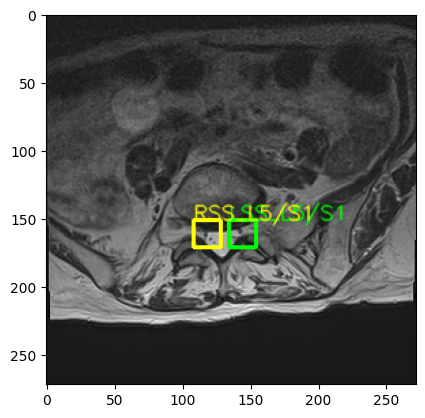

In [15]:
plt.imshow(img)
plt.show()

In [16]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [17]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [18]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [19]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

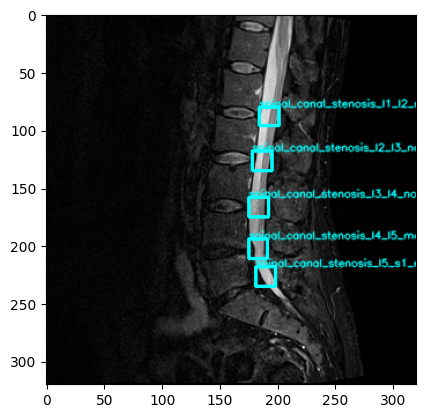

In [20]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [21]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-1y253ufo
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-1y253ufo
  Resolved https://github.com/ultralytics/ultralytics.git to commit 48843119913960a44901eb664f6d0f30544758dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.5-py3-none-any.whl size=881811 sha256=f6963628706efd3c5650c48da1a3487d3cdfe2692e3ed60de40d3ac70a29d429
  Stored in directory: /tmp/pip-ephem-wheel-cache-3oiiu2k0/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [22]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [23]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: spinal_canal_stenosis_l1_l2_normal/mild
    1: spinal_canal_stenosis_l1_l2_moderate
    2: spinal_canal_stenosis_l1_l2_severe
    3: spinal_canal_stenosis_l2_l3_normal/mild
    4: spinal_canal_stenosis_l2_l3_moderate
    5: spinal_canal_stenosis_l2_l3_severe
    6: spinal_canal_stenosis_l3_l4_normal/mild
    7: spinal_canal_stenosis_l3_l4_moderate
    8: spinal_canal_stenosis_l3_l4_severe
    9: spinal_canal_stenosis_l4_l5_normal/mild
    10: spinal_canal_stenosis_l4_l5_moderate
    11: spinal_canal_stenosis_l4_l5_severe
    12: spinal_canal_stenosis_l5_s1_normal/mild
    13: spinal_canal_stenosis_l5_s1_moderate
    14: spinal_canal_stenosis_l5_s1_severe

Writing yolo_scs.yaml


In [26]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandbkey")
wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
# Initialize W&B run
wandb.init(
    project="lsdc_yolov8",
#     name=f"Demo_fold0",
#     tags=["baseline", "search-lr", ],
    group=";".join(CONDITIONS),
#     config={
#         "lr": LR,
#         "model-name":"xtremedistill-trim",
#         "dataset": [
#             "raw_compettion",
#             "MPWare",
#             "Nicholas"
#         ]
#     }
)

wandb: Currently logged in as: harsha-vardhanreddy2020 (neha_lm). Use `wandb login --relogin` to force relogin


In [28]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO("yolov8s.pt")

# Add W&B callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune your model
# At the end of each epoch, predictions on validation batches are logged
# to a W&B table with insightful and interactive overlays for
# computer vision tasks
model.train(project="lsdc_yolov8", data="yolo_scs.yaml", 
            epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE)

# Finish the W&B run
wandb.finish()

100%|██████████| 21.5M/21.5M [00:00<00:00, 182MB/s]


Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=yolo_scs.yaml, epochs=40, time=None, patience=100, batch=64, imgsz=384, save=True, save_period=-1, cache=False, device=None, workers=8, project=lsdc_yolov8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]
2024-10-06 17:38:45,424	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-06 17:38:46,152	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 2013 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2013/2013 [00:02<00:00, 939.32it/s]

train: New cache created: /kaggle/working/data_fold0/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 509 images, 0 backgrounds, 0 corrupt: 100%|██████████| 509/509 [00:00<00:00, 901.69it/s] 

val: New cache created: /kaggle/working/data_fold0/labels/val.cache


Plotting labels to lsdc_yolov8/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov8/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.82G      4.194      6.172      2.149        211        384: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950          0          0          0          0
Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.81G      2.182      3.393      1.009        150        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        509       1950     0.0745     0.0855     0.0547     0.0179


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      7.23G      1.925      2.022     0.9773        154        384: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950     0.0766      0.439      0.175     0.0687


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       6.8G      1.848      1.715     0.9615        177        384: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.668      0.226      0.261     0.0953


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       6.8G      1.808      1.544     0.9514        228        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.646      0.332      0.377      0.158


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      7.24G       1.76      1.475     0.9468        164        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.659      0.429      0.444      0.199


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.79G      1.764      1.402     0.9467        151        384: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.477      0.515      0.444      0.201


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.93G      1.745      1.365     0.9438        140        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.427      0.598      0.488      0.231


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       6.8G      1.711      1.306     0.9352        137        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950      0.515      0.506      0.521      0.248


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      7.24G      1.737      1.307     0.9443        158        384: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.503       0.61       0.51      0.253


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.93G      1.683      1.277     0.9295        120        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        509       1950      0.545      0.616      0.494      0.246


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      7.24G      1.686       1.25     0.9344        131        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.412      0.614      0.502      0.244


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.85G      1.712      1.216     0.9374        145        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.517      0.613      0.501      0.234


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.81G      1.669      1.202      0.931        179        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.492       0.57      0.497      0.248


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      7.25G      1.656       1.18     0.9234        119        384: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.388      0.699      0.479      0.221


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      7.25G      1.652      1.176     0.9278        121        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.423      0.627      0.542      0.279


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      6.79G      1.611       1.15     0.9199        133        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.458      0.704      0.537      0.275


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.86G      1.612      1.187     0.9214        142        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        509       1950      0.595      0.593      0.535      0.271


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      6.81G      1.631      1.128     0.9232        128        384: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.513      0.623      0.546      0.275


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.83G      1.597      1.102     0.9185        152        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.517      0.664      0.546      0.267


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       6.8G      1.598      1.103     0.9195        161        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.467      0.636      0.533      0.264


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40       6.8G      1.571      1.106     0.9115        184        384: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.452       0.59      0.546      0.268


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      7.24G      1.597      1.092     0.9167        153        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.485      0.606      0.546       0.27


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.86G      1.583      1.077     0.9135        170        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.492      0.679       0.58      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      7.27G      1.559      1.074     0.9124        138        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.515      0.649      0.575      0.292


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      6.81G      1.548      1.064     0.9076        177        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        509       1950      0.494      0.659      0.575      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      7.27G      1.575      1.067     0.9135        195        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950      0.466      0.705      0.554      0.278


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      6.79G      1.548      1.062     0.9113        150        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950       0.49      0.638      0.565      0.282


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.81G      1.538       1.04     0.9016        146        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950       0.52      0.651      0.602      0.291


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      6.88G      1.542      1.036     0.9053        214        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.505      0.655        0.6      0.292


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      7.28G       1.53      1.003     0.9342        123        384: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.479      0.694       0.56      0.282


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      7.28G      1.489      1.005     0.9311        116        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.522      0.598      0.591      0.292


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      7.28G      1.483     0.9762     0.9265        119        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.544      0.626      0.594      0.308


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      7.28G      1.474     0.9866     0.9271        105        384: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.518      0.652      0.592      0.307


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      7.28G      1.467     0.9581      0.923        128        384: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950      0.509      0.647      0.572      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      7.28G      1.453     0.9546       0.92        110        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.491      0.671      0.595       0.31


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      6.79G      1.453     0.9467     0.9244        110        384: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        509       1950      0.501      0.673      0.597      0.305


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       6.8G      1.445     0.9361     0.9226        110        384: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.512      0.702      0.598      0.312


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.79G       1.44     0.9293     0.9202        122        384: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.504      0.692      0.605      0.315


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      7.28G      1.427     0.9237     0.9184        105        384: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950      0.508      0.667      0.599      0.312


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


40 epochs completed in 0.490 hours.
Optimizer stripped from lsdc_yolov8/train/weights/last.pt, 19.9MB
Optimizer stripped from lsdc_yolov8/train/weights/best.pt, 19.9MB

Validating lsdc_yolov8/train/weights/best.pt...
Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 9,833,469 parameters, 0 gradients, 23.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


                   all        509       1950      0.505      0.689      0.606      0.315
spinal_canal_stenosis_l1_l2_normal/mild        369        369      0.778      0.919       0.86      0.415
spinal_canal_stenosis_l1_l2_moderate          9          9      0.365       0.64      0.653      0.389
spinal_canal_stenosis_l1_l2_severe          2          2      0.363        0.5       0.62      0.211
spinal_canal_stenosis_l2_l3_normal/mild        350        350       0.78      0.906      0.844       0.42
spinal_canal_stenosis_l2_l3_moderate         27         27      0.316      0.519      0.328      0.175
spinal_canal_stenosis_l2_l3_severe          8          8      0.271      0.625      0.343      0.233
spinal_canal_stenosis_l3_l4_normal/mild        325        325      0.841      0.928      0.919      0.475
spinal_canal_stenosis_l3_l4_moderate         43         43      0.335      0.581      0.395      0.228
spinal_canal_stenosis_l3_l4_severe         27         27      0.482      0.828    

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to lsdc_yolov8/train


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███▇█████████
metrics/mAP50-95(B),▁▁▃▃▅▅▅▆▇▇▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇████████
metrics/precision(B),▁▂▂███▆▅▆▆▇▅▆▆▅▅▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆
metrics/recall(B),▁▂▅▃▄▅▆▇▆▇▇▇▇▇█▇█▇▇█▇▇▇█▇██▇▇██▇▇▇▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


spinal_canal_stenosis_l1_l2_normal/mild
spinal_canal_stenosis_l2_l3_normal/mild
spinal_canal_stenosis_l3_l4_normal/mild
spinal_canal_stenosis_l4_l5_normal/mild
spinal_canal_stenosis_l5_s1_normal/mild


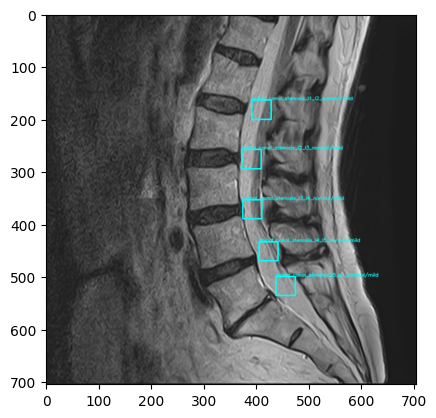

In [29]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [30]:
# Initialize YOLO Model
model = YOLO(glob.glob("lsdc_yolov8/*/weights/best.pt")[0])

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Perform prediction which automatically logs to a W&B Table
# with interactive overlays for bounding boxes, segmentation masks
out = model.predict([path], save=True, conf=0.2)

# Finish the W&B run
wandb.finish()


0: 384x384 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 1 spinal_canal_stenosis_l3_l4_normal/mild, 1 spinal_canal_stenosis_l4_l5_normal/mild, 1 spinal_canal_stenosis_l5_s1_normal/mild, 8.9ms
Speed: 3.0ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict
